In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# **Classifier Analysis**

In [ ]:
X = np.load('/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Augmented Complete Data/X_arr.npy')
y = np.load('/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Augmented Complete Data/y_arr.npy')

In [ ]:
# shape of augmented dataset
print(X.shape)
print(y.shape)

(3600, 204, 1290)
(3600,)


In [ ]:
# StandardScaler expected <= 2
# Flatten the last two dimensions:
X_flattened = X.reshape(X.shape[0], -1)

# Then you can scale and split the data as before
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flattened)

In [ ]:
print(X_flattened.shape)

(3600, 263160)


In [ ]:
y = y.astype(int)  # Convert y to integer type
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import label_binarize

In [ ]:
'''
Classifiers on augmented datasets: 3600 ~30s
'''

# Initialize classifiers
classifiers = {
    "LR": LogisticRegression(max_iter=2500),
    "RC": RidgeClassifier(),
    "LSVM": LinearSVC(),
    "SVM": SVC(probability=True),
    "RFC": RandomForestClassifier(),
    "ABC": AdaBoostClassifier(),
    "GNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "OvRC": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "KNC": KNeighborsClassifier(),
    "MLP": MLPClassifier()
}


# Binarize the y_test for ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

n_genres = len(np.unique(y))
score = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()
confusion_mats = dict()

# Iterate over classifiers to train and evaluate
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    score[name] = clf.score(X_test, y_test)
    fpr[name], tpr[name], roc_auc[name] = {}, {}, {}
    confusion_mats[name] = np.zeros((n_genres, n_genres))

    # Compute ROC curve and ROC area for each class
    if name in ["LSVM", "SVM", "RC"]:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)

    for i in range(n_genres):
        fpr[name][i], tpr[name][i], _ = metrics.roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[name][i] = metrics.auc(fpr[name][i], tpr[name][i])

        # Confusion matrix for each class
        y_pred = clf.predict(X_test)
        for j in range(n_genres):
            confusion_mats[name][i, j] = np.sum((y_test == i) & (y_pred == j))

# Plotting
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for idx, (name, clf) in enumerate(classifiers.items()):
    for i in range(n_genres):
        axs[idx // 4, idx % 4].plot(fpr[name][i], tpr[name][i], label=f'Class {i}, AUC: {roc_auc[name][i]:.2f}')
    axs[idx // 4, idx % 4].set_title(f"{name}, test accuracy = {round(score[name], 3)}")
    axs[idx // 4, idx % 4].legend()

fig.tight_layout()
plt.show()

# **Classfiers on large dataset**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


In [ ]:
def data_loader(X_data, y_data, batch_size):
    num_samples = len(X_data)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        yield X_data[start_idx:end_idx], y_data[start_idx:end_idx]

In [5]:
X_train = torch.load("/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Complete/X_train_59.pt")
y_train = torch.load("/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Complete/y_train_59.pt")

X_test = torch.load("/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Complete/X_test_59.pt")
y_test = torch.load("/content/drive/MyDrive/EN.553.602DataMiningSpring2024/dataset/Complete/y_test_59.pt")

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([9787, 204, 1000])
torch.Size([9787])
torch.Size([1399, 204, 1000])
torch.Size([1399])


In [16]:
X_train_flattened = X_train.view(X_train.shape[0], -1)
X_test_flattened = X_test.view(X_test.shape[0], -1)

In [17]:
print(X_train_flattened.shape)
print(X_test_flattened.shape)

torch.Size([9787, 204000])
torch.Size([1399, 204000])


In [18]:
train_dataset = TensorDataset(X_train_flattened.float(), y_train.long())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [11]:
# Define the multi-class logistic regression model
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [20]:
input_dim = X_train_flattened.shape[1]
num_classes = torch.max(y_train) + 1

print(input_dim)
print(num_classes)

204000
tensor(59)


In [27]:
model = MulticlassLogisticRegression(input_dim, num_classes)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # 前向传播
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/200], Loss: 174.8233
Epoch [10/200], Loss: 116.2426
Epoch [15/200], Loss: 114.2703
Epoch [20/200], Loss: 114.1661
Epoch [25/200], Loss: 56.3519
Epoch [30/200], Loss: 43.7061
Epoch [35/200], Loss: 30.5244
Epoch [40/200], Loss: 24.4814
Epoch [45/200], Loss: 45.4094
Epoch [50/200], Loss: 35.3326
Epoch [55/200], Loss: 52.8551
Epoch [60/200], Loss: 18.2150
Epoch [65/200], Loss: 16.4962
Epoch [70/200], Loss: 21.6711
Epoch [75/200], Loss: 35.5331
Epoch [80/200], Loss: 12.5553
Epoch [85/200], Loss: 17.4314
Epoch [90/200], Loss: 21.5654
Epoch [95/200], Loss: 11.4659
Epoch [100/200], Loss: 9.0161
Epoch [105/200], Loss: 16.1543
Epoch [110/200], Loss: 11.9012
Epoch [115/200], Loss: 14.7359
Epoch [120/200], Loss: 22.5222
Epoch [125/200], Loss: 11.1438
Epoch [130/200], Loss: 8.0509
Epoch [135/200], Loss: 8.6761
Epoch [140/200], Loss: 22.4363
Epoch [145/200], Loss: 11.7329
Epoch [150/200], Loss: 14.0897
Epoch [155/200], Loss: 12.6832
Epoch [160/200], Loss: 3.7313
Epoch [165/200], Loss: 8.418

Accuracy on test data: 43.75%


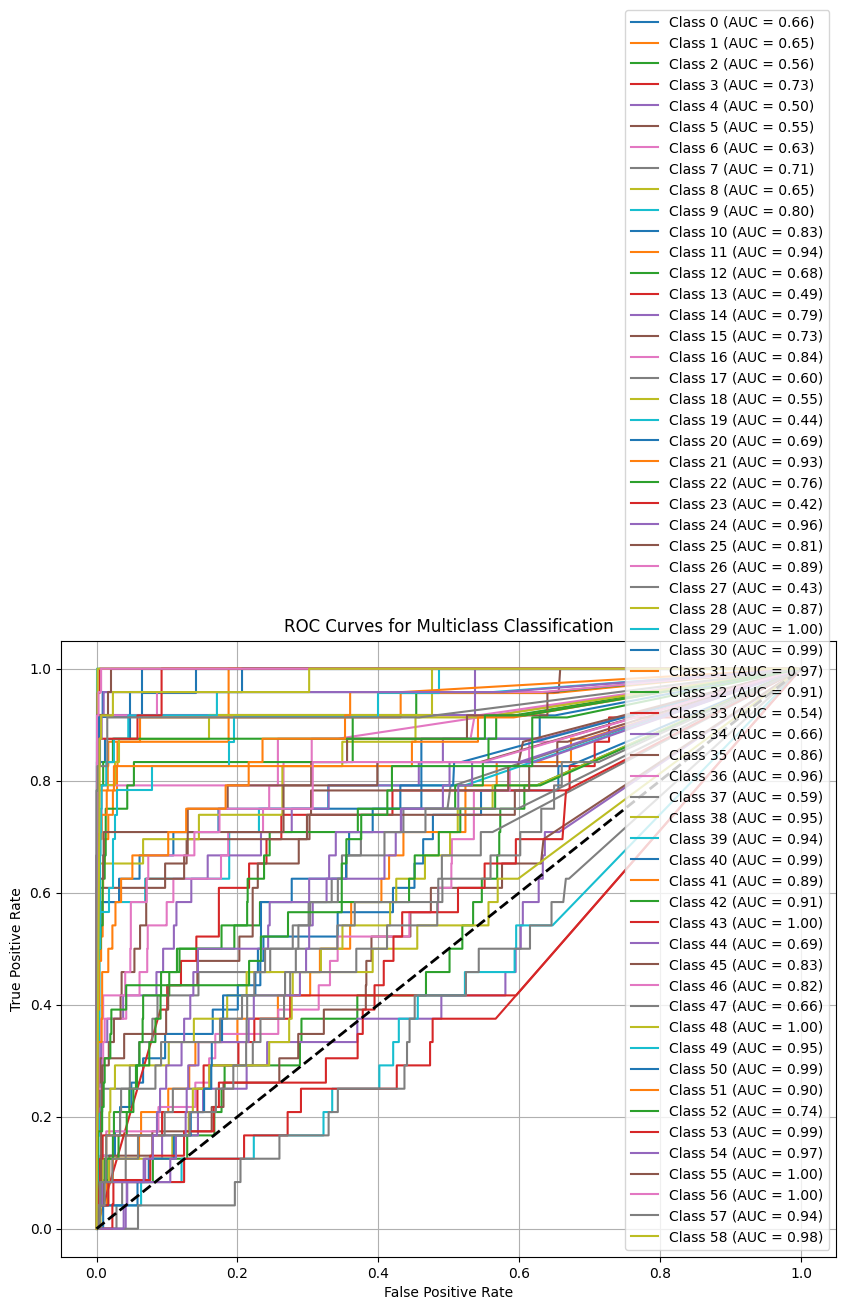

In [28]:
with torch.no_grad():
    # 确保测试集是 float 类型
    X_test_flattened = X_test_flattened.float()
    # 获取测试集上的模型输出
    test_outputs = model(X_test_flattened)
    test_probs = F.softmax(test_outputs, dim=1).numpy()
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f'Accuracy on test data: {accuracy.item() * 100:.2f}%')

# 将真实目标变量进行 one-hot 编码
y_test_binarized = label_binarize(y_test, classes=list(range(num_classes)))

# 初始化 ROC 曲线和 AUC 数值的存储容器
fpr = {}
tpr = {}
roc_auc = {}

# 为每个类别计算 ROC 曲线和 AUC 数值
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制多类别 ROC 曲线
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# 添加基准线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 添加图例、标签和标题
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()